## Set-up (BERTje + spaCy + utilities laden)

In [8]:
!pip install transformers sentencepiece spacy --quiet
!python -m spacy download nl_core_news_md

from transformers import pipeline
import spacy

# spacy
nlp = spacy.load("nl_core_news_md")

# load bertje
fill_mask = pipeline("fill-mask", model="GroNLP/bert-base-dutch-cased")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/254 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


## CEL 2 — Imports + modellen + bitfuncties

In [9]:
from transformers import pipeline
import spacy
import math

MODE = "baseline"  # baseline / lowrisk / highrisk

# spacy
nlp = spacy.load("nl_core_news_md")

# bertje fill mask pipeline
fill_mask = pipeline("fill-mask", model="GroNLP/bert-base-dutch-cased")


def text_to_bits(text):
    return ''.join(format(ord(c), '08b') for c in text)

def bits_to_text(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) == 8:
            chars.append(chr(int(byte, 2)))
    return ''.join(chars)

Device set to use cpu


## CEL 3 — Nouns + BERT candidates + stabiele filter

In [10]:
# nouns (token indices, stabiel)
def find_noun_token_idxs(sentence):
    doc = nlp(sentence)
    return [i for i, t in enumerate(doc) if t.pos_ == "NOUN"]


def mask_sentence_at_token(sentence, token_idx):
    """
    Maak exact één token [MASK], zonder .replace() (dus geen dubbele vervangingen).
    Bewaar whitespace zodat tokenisatie stabiel blijft.
    """
    doc = nlp(sentence)
    parts = [t.text_with_ws for t in doc]
    parts[token_idx] = "[MASK]" + doc[token_idx].whitespace_
    return "".join(parts).strip()


# candidates (op token index)
def get_mask_candidates(sentence, token_idx):
    masked = mask_sentence_at_token(sentence, token_idx)
    preds = fill_mask(masked)
    return [(p["token_str"].strip(), p["score"]) for p in preds]


def filter_candidates(cands, original_word, mode="baseline"):
    cleaned = []

    for w, s in cands:
        w = w.strip()

        # basic filtering
        if not w.isalpha():
            continue
        if w.lower() in ["unk", "[unk]"]:
            continue
        if w.startswith("##"):
            continue
        if w == original_word:
            continue

        # LOW RISK
        if mode == "lowrisk":
            if s < 0.03:
                continue
            if abs(len(w) - len(original_word)) > 2:
                continue

        # BASELINE
        elif mode == "baseline":
            if s < 0.01:
                continue
            if abs(len(w) - len(original_word)) > 4:
                continue

        # HIGH RISK
        elif mode == "highrisk":
            if s < 0.0001:
                continue

        cleaned.append(w)

    # deterministisch, maar let op: dit gooit ranking weg (oké voor nu)
    cleaned = sorted(set(cleaned))

    # enforce capacities
    if mode == "lowrisk":
        return cleaned[:2]     # 1 bit max
    if mode == "baseline":
        return cleaned[:8]     # 3 bits max
    if mode == "highrisk":
        return cleaned[:32]    # 5 bits max

    return cleaned



## CEL 4 — Encoder (met candidate_db opslag!)

In [11]:
MODE = "baseline"   # lowrisk / baseline / highrisk

candidate_db = {}

def make_bit_mapping(candidates):
    k = len(candidates)
    bits_needed = math.ceil(math.log2(k))

    mapping = {}
    for i, w in enumerate(candidates):
        bitcode = format(i, f"0{bits_needed}b")
        mapping[bitcode] = w

    return mapping, bits_needed


def encode_word(sentence, token_idx, original_word, candidates, bitstream, li):
    mapping, bits_needed = make_bit_mapping(candidates)

    if len(bitstream) < bits_needed:
        return sentence, bitstream, False

    bits = bitstream[:bits_needed]
    chosen = mapping.get(bits)
    if chosen is None:
        return sentence, bitstream, False

    doc = nlp(sentence)
    if token_idx >= len(doc):
        return sentence, bitstream, False

    # vervang exact dit token, behoud whitespace
    parts = [t.text_with_ws for t in doc]
    parts[token_idx] = chosen + doc[token_idx].whitespace_
    out = "".join(parts).strip()

    rest = bitstream[bits_needed:]

    print(f"[ENC] line={li}, tok_i={token_idx}, noun='{original_word}', bits_used={bits}, chosen='{chosen}'")
    return out, rest, True


def encode_text(text, bitstream):
    global candidate_db
    candidate_db = {}

    lines = [l.strip() for l in text.split("\n") if l.strip()]
    stego_lines = []

    for li, line in enumerate(lines):
        if bitstream == "":
            stego_lines.append(line)
            continue

        # bepaal noun token indices op basis van huidige line
        noun_idxs = find_noun_token_idxs(line)

        for tok_i in noun_idxs:
            if bitstream == "":
                break

            # haal original word op (op dit moment)
            doc = nlp(line)
            if tok_i >= len(doc):
                continue
            original_word = doc[tok_i].text

            raw = get_mask_candidates(line, tok_i)
            cands = filter_candidates(raw, original_word, mode=MODE)
            if len(cands) < 2:
                continue

            new_line, new_bitstream, consumed = encode_word(
                line, tok_i, original_word, cands, bitstream, li
            )

            # sla alleen op als er echt bits embed zijn
            if consumed:
                candidate_db[(li, tok_i)] = cands
                line, bitstream = new_line, new_bitstream

        stego_lines.append(line)

    return "\n".join(stego_lines), bitstream


### CEL 5- TEKST LOADER

In [12]:
import os

COVER_DIR = "/content/cover_texts"

def load_cover_texts(directory):
    texts = {}
    for fname in sorted(os.listdir(directory)):
        if fname.endswith(".txt"):
            with open(os.path.join(directory, fname), encoding="utf-8") as f:
                texts[fname] = f.read().strip()
    return texts

cover_texts = load_cover_texts(COVER_DIR)

print("Loaded texts:")
for k, v in cover_texts.items():
    print(k, "→", len(v.split()), "woorden")


Loaded texts:
1.txt → 203 woorden
2.txt → 277 woorden
3.txt → 257 woorden
4.txt → 300 woorden
5.txt → 631 woorden
6.txt → 608 woorden
7.txt → 591 woorden
8.txt → 574 woorden


### CEL 6- DECODER

In [13]:
def normalize(w):
    return w.lower().strip(".,!?;:()[]\"'")

def decode_word_by_token_index(stego_line, token_idx, candidates):
    sdoc = nlp(stego_line)
    if token_idx >= len(sdoc):
        return None

    stego_word = normalize(sdoc[token_idx].text)
    cands_norm = [normalize(c) for c in candidates]

    if stego_word not in cands_norm:
        return None

    idx = cands_norm.index(stego_word)
    bits_needed = math.ceil(math.log2(len(candidates)))
    return format(idx, f"0{bits_needed}b")


def decode_text(stego_text, original_text):
    lines_s = [l.strip() for l in stego_text.split("\n") if l.strip()]
    lines_o = [l.strip() for l in original_text.split("\n") if l.strip()]

    full_bits = ""

    for li, (sline, oline) in enumerate(zip(lines_s, lines_o)):
        odoc = nlp(oline)

        for tok_i, tok in enumerate(odoc):
            if tok.pos_ != "NOUN":
                continue

            key = (li, tok_i)
            if key not in candidate_db:
                continue

            cands = candidate_db[key]
            bitcode = decode_word_by_token_index(sline, tok_i, cands)

            if bitcode:
                full_bits += bitcode
                print(f"[DEC] line={li}, tok_i={tok_i}, noun='{tok.text}', bitcode={bitcode}, cands={cands}")

    return full_bits, bits_to_text(full_bits)

## CEL 7 - Cover text + geheime boodschap

In [15]:
MODE = "highrisk"
cover = cover_texts["1.txt"]

secret = "HALLO"
bits = text_to_bits(secret)
needed = len(bits)

# encode
stego, leftover = encode_text(cover, bits)
print("Leftover bits:", len(leftover))

print("\n--- STEGO TEXT ---\n")
print(stego)

# maak verschillen bold
def bold_differences(cover_text, stego_text):
    cover_lines = cover_text.splitlines()
    stego_lines = stego_text.splitlines()
    out_cover, out_stego = [], []

    for c_line, s_line in zip(cover_lines, stego_lines):
        c_words = c_line.split(" ")
        s_words = s_line.split(" ")

        # als lengte verschilt, geef gewoon hele regel terug
        if len(c_words) != len(s_words):
            out_cover.append(c_line)
            out_stego.append(s_line)
            continue

        c_out = []
        s_out = []
        for cw, sw in zip(c_words, s_words):
            if cw != sw:
                c_out.append(f"**{cw}**")
                s_out.append(f"**{sw}**")
            else:
                c_out.append(cw)
                s_out.append(sw)

        out_cover.append(" ".join(c_out))
        out_stego.append(" ".join(s_out))

    return "\n".join(out_cover), "\n".join(out_stego)

cover_bold, stego_bold = bold_differences(cover, stego)

print("\n--- COVER (changes in bold) ---\n")
print(cover_bold)

print("\n--- STEGO (changes in bold) ---\n")
print(stego_bold)

# decode
decoded_bits, decoded_text = decode_text(stego, cover)
print("\nDecoded text (raw):", decoded_text)

# trim exact
decoded_bits_trim = decoded_bits[:needed]
decoded_text_trim = bits_to_text(decoded_bits_trim)
print("Decoded text (trimmed):", decoded_text_trim)

print("Match:", decoded_text_trim == secret)



[ENC] line=0, tok_i=1, noun='intelligentie', bits_used=01, chosen='training'
[ENC] line=0, tok_i=7, noun='intelligentie', bits_used=00, chosen='oefening'
[ENC] line=0, tok_i=16, noun='vaardigheden', bits_used=10, chosen='gedachten'
[ENC] line=0, tok_i=19, noun='computersysteem', bits_used=000, chosen='doel'
[ENC] line=0, tok_i=29, noun='plannen', bits_used=100, chosen='trainen'
[ENC] line=1, tok_i=4, noun='team', bits_used=00, chosen='combinatie'
[ENC] line=1, tok_i=6, noun='software', bits_used=01, chosen='onafhankelijke'
[ENC] line=1, tok_i=7, noun='engineers', bits_used=010, chosen='ingenieurs'
[ENC] line=1, tok_i=19, noun='tussenkomst', bits_used=01, chosen='hulp'
[ENC] line=1, tok_i=22, noun='intelligentie', bits_used=100, chosen='tussenkomst'
[ENC] line=2, tok_i=1, noun='intelligentie', bits_used=01, chosen='kennis'
[ENC] line=2, tok_i=6, noun='technieken', bits_used=001, chosen='factoren'
[ENC] line=2, tok_i=12, noun='besluitvorming', bits_used=10, chosen='à'
[ENC] line=2, tok_i

### STATISTIEKEN EN GRAFIEKEN

## Basisstatistieken

In [31]:
import pandas as pd

modes = ["lowrisk", "baseline", "highrisk"]

secrets = [
    "HALLO",
    "HELP ME",
    "TEST",
    "KAN BERTJE INFORMATIE VERSTOPPEN?",
    "DIT IS EEN GEHEIME BOODSCHAP",
    "JOHAN DRAAGT EEN PET",
]

cover_names = [f"{i}.txt" for i in range(1, 9)]
results = []

for cover_name in cover_names:
    cover = cover_texts[cover_name]

    for mode in modes:
        MODE = mode  # gebruikt door filter_candidates

        for secret in secrets:
            bits = text_to_bits(secret)
            secret_bits = len(bits)

            stego, leftover = encode_text(cover, bits)
            leftover_bits = len(leftover)
            embedded_bits = secret_bits - leftover_bits

            decoded_bits, decoded_text = decode_text(stego, cover)

            # Trim ALTIJD op secret_bits (wat je wilde terugkrijgen)
            decoded_trim = bits_to_text(decoded_bits[:secret_bits]) if len(decoded_bits) >= 8 else ""

            # succes = alles embedded + exact terug
            success_full = (leftover_bits == 0 and decoded_trim == secret)

            results.append({
                "cover": cover_name,
                "mode": mode,
                "secret": secret,
                "secret_bits": secret_bits,
                "embedded_bits": embedded_bits,
                "leftover_bits": leftover_bits,
                "decoded_trim": decoded_trim,
                "success_full": success_full,
            })

df = pd.DataFrame(results)

summary = df.groupby("mode").agg(
    runs=("success_full", "count"),
    success=("success_full", "sum"),
    success_rate=("success_full", "mean"),
    avg_embedded_bits=("embedded_bits", "mean"),
    avg_leftover_bits=("leftover_bits", "mean"),
).reset_index()

print("=== SUMMARY PER MODE ===")
print(summary)

print("\n=== TOP FAILURES (leftover>0 or mismatch) ===")
failures = df[df["success_full"] == False].head(15)
print(failures[["cover","mode","secret_bits","embedded_bits","leftover_bits","decoded_trim"]])


Streaminguitvoer ingekort tot de laatste 5000 regels.
[DEC] line=3, tok_i=78, noun='benadering', bitcode=011, cands=['filosofie', 'samenleving', 'systeem', 'systemen', 'theorie']
[DEC] line=3, tok_i=81, noun='accenten', bitcode=01, cands=['accent', 'beperkingen', 'nadruk']
[DEC] line=3, tok_i=87, noun='regels', bitcode=01, cands=['gedrag', 'normen', 'waarden']
[DEC] line=3, tok_i=92, noun='welzijn', bitcode=00, cands=['normen', 'regels', 'relaties', 'waarden']
[DEC] line=3, tok_i=96, noun='ethiek', bitcode=0, cands=['er', 'het']
[DEC] line=3, tok_i=102, noun='mensen', bitcode=10, cands=['individuen', 'organismen', 'waarden', 'we']
[DEC] line=3, tok_i=106, noun='principes', bitcode=1, cands=['normen', 'waarden']
[DEC] line=3, tok_i=107, noun='richting', bitcode=00, cands=['betekenis', 'inhoud', 'uitdrukking', 'vorm']
[DEC] line=4, tok_i=2, noun='ethiek', bitcode=10, cands=['mens', 'overheid', 'politiek', 'wereld']
[DEC] line=4, tok_i=10, noun='vraagstukken', bitcode=0, cands=['ontwikkel

In [9]:
df_long = df[df["cover"].isin(["5.txt","6.txt","7.txt","8.txt"])]

df_long.groupby("mode").agg(
    runs=("success_full","count"),
    success=("success_full","sum"),
    success_rate=("success_full","mean"),
    avg_embedded_bits=("embedded_bits","mean"),
    avg_leftover_bits=("leftover_bits","mean")
)
# woorden per cover bepalen
cover_word_counts = {
    name: len(text.split())
    for name, text in cover_texts.items()
}

# toevoegen aan dataframe
df["cover_words"] = df["cover"].map(cover_word_counts)

# bits per 100 woorden
df["bits_per_100_words"] = (df["embedded_bits"] / df["cover_words"]) * 100


bits_per_100_summary = df.groupby("mode").agg(
    avg_bits_per_100_words=("bits_per_100_words", "mean"),
    std_bits_per_100_words=("bits_per_100_words", "std"),
).reset_index()

print("=== BITS PER 100 WORDEN (PER MODE) ===")
print(bits_per_100_summary)



=== BITS PER 100 WORDEN (PER MODE) ===
       mode  avg_bits_per_100_words  std_bits_per_100_words
0  baseline               21.300547               10.943120
1  highrisk               27.114673               17.432956
2   lowrisk                8.319455                1.704441


In [28]:
df_short = df[df["cover"].isin(["1.txt","2.txt","3.txt","4.txt"])]
df_long  = df[df["cover"].isin(["5.txt","6.txt","7.txt","8.txt"])]

def summarize(d):
    return d.groupby("mode").agg(
        runs=("success_full","count"),
        success=("success_full","sum"),
        success_rate=("success_full","mean"),
        avg_bits_per_100=("bits_per_100_words","mean"),
        avg_leftover_bits=("leftover_bits","mean"),
    ).reset_index()

print("=== SHORT (1–4) ===")
print(summarize(df_short))
print("\n=== LONG (5–8) ===")
print(summarize(df_long))

df["completion_rate"] = df["embedded_bits"] / df["secret_bits"]

completion = df.groupby("mode").agg(
    avg_completion=("completion_rate","mean"),
    std_completion=("completion_rate","std"),
).reset_index()

print("=== COMPLETION RATE PER MODE ===")
print(completion)


=== SHORT (1–4) ===
       mode  runs  success  success_rate  avg_bits_per_100  avg_leftover_bits
0  baseline    24       11      0.458333         22.628081          70.791667
1  highrisk    24       10      0.416667         32.697187          44.666667
2   lowrisk    24        0      0.000000          8.052068         108.458333

=== LONG (5–8) ===
       mode  runs  success  success_rate  avg_bits_per_100  avg_leftover_bits
0  baseline    24       17      0.708333         19.973013           9.333333
1  highrisk    24       21      0.875000         21.532159           0.083333
2   lowrisk    24       11      0.458333          8.586843          77.750000
=== COMPLETION RATE PER MODE ===
       mode  avg_completion  std_completion
0  baseline        0.820119        0.278651
1  highrisk        0.902380        0.194584
2   lowrisk        0.477763        0.347823


=== DETECTABILITY PROXIES PER MODE ===
       mode  runs  avg_subs_per_100  std_subs_per_100  mismatch_rate
0  baseline     6         11.904762          1.956023            0.0
1  highrisk     6         12.643678          4.733509            0.5
2   lowrisk    11          8.419329          1.204395            0.0


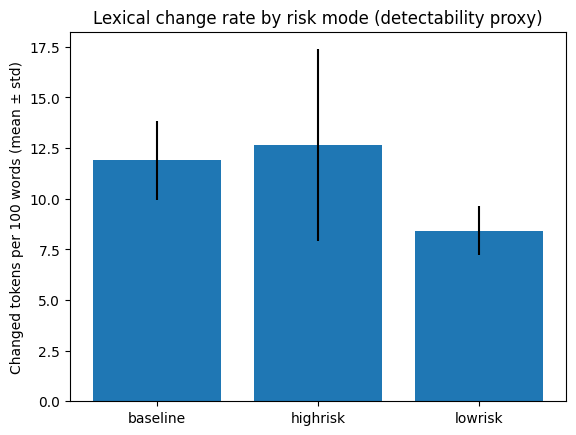

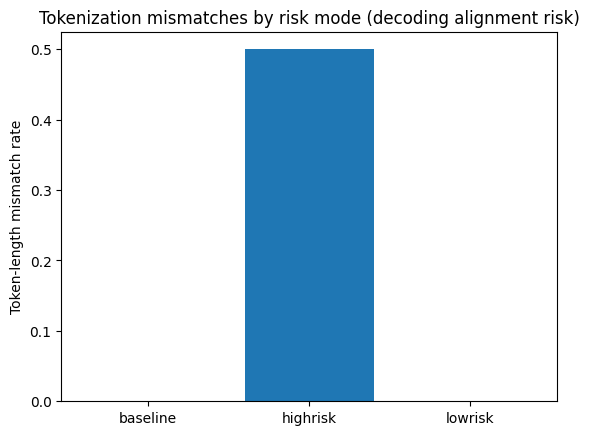

In [30]:
df_det = pd.DataFrame(rows)

# aggregaties
agg = df_det.groupby("mode").agg(
    runs=("mode","count"),
    avg_subs_per_100=("subs_per_100_words","mean"),
    std_subs_per_100=("subs_per_100_words","std"),
    mismatch_rate=("length_match", lambda x: 1 - np.mean(x)),  # 1 - match
).reset_index()

print("=== DETECTABILITY PROXIES PER MODE ===")
print(agg)

# substitutions per 100 words (mean ± std)
plt.figure()
x = np.arange(len(agg["mode"]))
y = agg["avg_subs_per_100"].values
yerr = agg["std_subs_per_100"].fillna(0).values
plt.bar(x, y, yerr=yerr)
plt.xticks(x, agg["mode"].values)
plt.ylabel("Changed tokens per 100 words (mean ± std)")
plt.title("Lexical change rate by risk mode (detectability proxy)")
plt.show()

# tokenization mismatch rate
plt.figure()
plt.bar(x, agg["mismatch_rate"].values)
plt.xticks(x, agg["mode"].values)
plt.ylabel("Token-length mismatch rate")
plt.title("Tokenization mismatches by risk mode (decoding alignment risk)")
plt.show()

/tmp/ipython-input-2190342368.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=modes_order, showmeans=True)


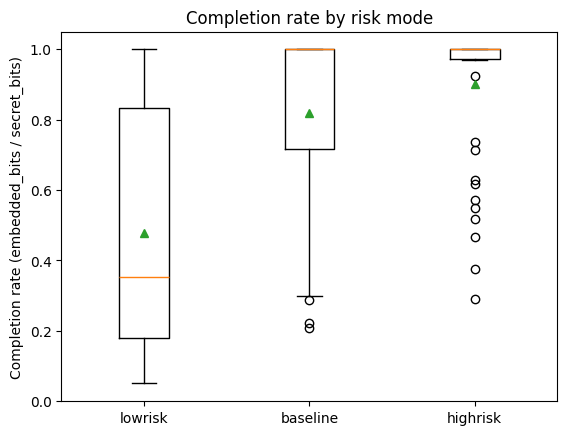

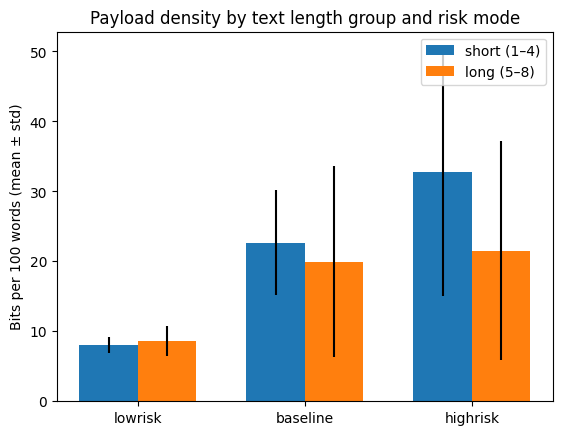

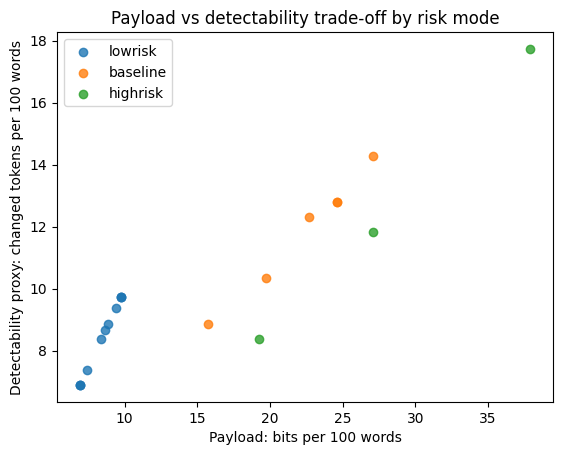


=== TRADE-OFF SUMMARY (MEANS) ===
       mode  avg_bits_per_100  avg_subs_per_100  mismatch_rate
0  baseline         22.413793         11.904762            0.0
1  highrisk         28.078818         12.643678            0.0
2   lowrisk          8.419329          8.419329            0.0


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io


def cover_group(name):
    # 1-4 short, 5-8 long
    try:
        idx = int(name.split(".")[0])
        return "short (1–4)" if idx <= 4 else "long (5–8)"
    except:
        return "unknown"

if "cover_words" not in df.columns:
    cover_word_counts = {name: len(text.split()) for name, text in cover_texts.items()}
    df["cover_words"] = df["cover"].map(cover_word_counts)

if "bits_per_100_words" not in df.columns:
    df["bits_per_100_words"] = (df["embedded_bits"] / df["cover_words"]) * 100

if "completion_rate" not in df.columns:
    df["completion_rate"] = df["embedded_bits"] / df["secret_bits"]

df["group"] = df["cover"].apply(cover_group)


plt.figure()
modes_order = ["lowrisk", "baseline", "highrisk"]
data = [df.loc[df["mode"] == m, "completion_rate"].dropna().values for m in modes_order]
plt.boxplot(data, labels=modes_order, showmeans=True)
plt.ylabel("Completion rate (embedded_bits / secret_bits)")
plt.title("Completion rate by risk mode")
plt.ylim(0, 1.05)
plt.show()

agg_sl = df.groupby(["group", "mode"]).agg(
    mean_bits=("bits_per_100_words", "mean"),
    std_bits=("bits_per_100_words", "std"),
    n=("bits_per_100_words", "count"),
).reset_index()

groups_order = ["short (1–4)", "long (5–8)"]
x = np.arange(len(modes_order))
width = 0.35

plt.figure()
for gi, g in enumerate(groups_order):
    sub = agg_sl[agg_sl["group"] == g].set_index("mode").reindex(modes_order)
    means = sub["mean_bits"].values
    stds = sub["std_bits"].fillna(0).values
    plt.bar(x + (gi-0.5)*width, means, width=width, yerr=stds, label=g)

plt.xticks(x, modes_order)
plt.ylabel("Bits per 100 words (mean ± std)")
plt.title("Payload density by text length group and risk mode")
plt.legend()
plt.show()

need_build = "df_det" not in globals()

if need_build:
    silent = io.StringIO()

    def token_diff_stats(cover_text: str, stego_text: str):
        cdoc = nlp(cover_text)
        sdoc = nlp(stego_text)
        if len(cdoc) != len(sdoc):
            return np.nan, np.nan, False
        changed = sum(1 for ct, st in zip(cdoc, sdoc) if ct.text != st.text)
        return changed, len(cdoc), True

    rows = []
    for _, r in df.iterrows():
        cover_name = r["cover"]
        mode = r["mode"]
        secret = r["secret"]
        cover = cover_texts[cover_name]
        bits = text_to_bits(secret)

        MODE = mode

        with redirect_stdout(silent):
            stego, _ = encode_text(cover, bits)

        changed, _, length_match = token_diff_stats(cover, stego)
        cover_words = len(cover.split())
        subs_per_100_words = (changed / cover_words) * 100 if cover_words > 0 and length_match else np.nan

        rows.append({
            "cover": cover_name,
            "mode": mode,
            "secret": secret,
            "subs_per_100_words": subs_per_100_words,
            "length_match": length_match,
        })

    df_det = pd.DataFrame(rows)

# Merge payload with detectability
df_trade = df.merge(
    df_det[["cover", "mode", "secret", "subs_per_100_words", "length_match"]],
    on=["cover", "mode", "secret"],
    how="left"
)

# only keep rows where substitution
df_trade_clean = df_trade.dropna(subset=["subs_per_100_words", "bits_per_100_words"])

plt.figure()
for m in modes_order:
    sub = df_trade_clean[df_trade_clean["mode"] == m]
    plt.scatter(sub["bits_per_100_words"].values, sub["subs_per_100_words"].values, label=m, alpha=0.8)

plt.xlabel("Payload: bits per 100 words")
plt.ylabel("Detectability proxy: changed tokens per 100 words")
plt.title("Payload vs detectability trade-off by risk mode")
plt.legend()
plt.show()

# table for the trade-off plot
trade_summary = df_trade_clean.groupby("mode").agg(
    avg_bits_per_100=("bits_per_100_words", "mean"),
    avg_subs_per_100=("subs_per_100_words", "mean"),
    mismatch_rate=("length_match", lambda x: 1 - np.mean(x)),
).reset_index()

print("\n=== TRADE-OFF SUMMARY ===")
print(trade_summary)
